# Machine Performance

The question: What can you tell me about my machine? 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from statsmodels.stats.weightstats import ztest

from datetime import datetime

import seaborn as sns
sns.set_theme()

import matplotlib.gridspec as gridspec

# Data Processing 

Step one in this analysis is to understand what data we have and look at how we can prepare to use it. This covers everything from finding out what features we have to cleaning null values. Let's dive right in:

In [2]:
#load data and take a look
machine_data=pd.read_csv('sample_interview_dataset.csv',index_col=0)
print(machine_data.head(3))

       Machine Type  Air temperature [K]  Process temperature [K]  \
UID                                                                 
M14860           x1                298.1                    308.6   
L47181          x_1                298.2                    308.7   
L47182          x_1                298.1                    308.5   

        Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  \
UID                                                                    
M14860                  1551.0         42.8                0       0   
L47181                  1408.0         46.3                3       0   
L47182                  1498.0         49.4                5       0   

       Failure Type            Timestamp  
UID                                       
M14860   No Failure  2001-12-01 00:00:00  
L47181   No Failure  2001-12-01 01:00:00  
L47182   No Failure  2001-12-01 02:00:00  


In [3]:
print(machine_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, M14860 to M24859
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Machine Type             10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   9900 non-null   float64
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Target                   10000 non-null  int64  
 7   Failure Type             10000 non-null  object 
 8   Timestamp                10000 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 781.2+ KB
None


Great, we can already see we have interesting features and information about types of failure. Let's take a look at the different failure types:

In [4]:
machine_data['Failure Type'].value_counts()

No Failure                  9553
Heat Dissipation Failure     112
Error                        100
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               17
Name: Failure Type, dtype: int64

As we have a nice clear breakdown of 6 types of failure, this will a sensible structure for our anaylsis. The plan now is to go through each issue and try and find information in the feature that may help us understand what is happening. Before we start this, it's important to understand what ourtiler we may have and to clean up our data 

## Timestamps 

The first feature I wanted to look at is the timestamp 

In [5]:
#when we printed out data it was apparent that timestamp copuld be converted to datetime
machine_data['Timestamp']=pd.to_datetime(machine_data['Timestamp'])

In [6]:
#see which years our data is from
display(machine_data['Timestamp'].apply(lambda z: z.year).value_counts().sort_index())

2001     731
2002    8683
2003     486
2011      13
2012      77
2013      10
Name: Timestamp, dtype: int64

No we have our first concerning sign, which is the date split into two time periods, separated by 10 years. It's possible this is correct but it seems like a potential recording error may be more likely. To check this let's write a function to shift the later times back 10 years, then check that these are the "missing" times.

In [7]:
def time_correct(time):
    if time > datetime(2004,1,1,0,0,0):
        correct_time=datetime(time.year-10, time.month, time.day, time.hour, time.minute, time.second)
    else: 
        correct_time=time
    return correct_time

In [8]:
time_counts=machine_data['Timestamp'].apply(time_correct).value_counts()
print(f'Overlaping dates: {np.shape(time_counts[time_counts>1])[0]}')

display(machine_data['Timestamp'].apply(time_correct).apply(lambda z: z.year).value_counts().sort_index())

Overlaping dates: 0


2001     744
2002    8760
2003     496
Name: Timestamp, dtype: int64

We can see that there is no overlap between the early or late dates after correction. This means that either this is a coincidence and it just  happens that the machine was run on exactly the "missing" dates, or far more likely there has been a recording error. On the basis of this, let's apply this correction to our dataset. 

In [9]:
machine_data['Timestamp']=machine_data['Timestamp'].apply(time_correct)


## Discrepancy between Target and Failure type 

We have failure types and a feature names "target", let's check to see how these relate to each other. First we can see that we have instances of both target values labeled as "No Failure": 

In [10]:
No_failure=machine_data[machine_data['Failure Type']=='No Failure']
print(No_failure['Target'].value_counts())

0    9544
1       9
Name: Target, dtype: int64


Now check how the non-target data is labeled: 

In [11]:
No_target=machine_data[machine_data['Target']==0]
print(No_target['Failure Type'].value_counts())

No Failure         9544
Error               100
Random Failures      17
Name: Failure Type, dtype: int64


We can see that some of out non-target data is labeled as errors or failures. On the basis of this discrepancy, I decided to use the failure type feature for this analysis, whcih also happens to be more discriptive.  

## Machine Data 

In [12]:
print(machine_data['Machine Type'].value_counts())

x_1    5937
x1     2974
X1      989
X2      100
Name: Machine Type, dtype: int64


We can see that we have 4 categories for machine type but 3 are just different versions of X1, the first step will be to combine these. We can also see that there were only 100 hours of data and 3 errors for the X2 machine so it is advisable to drop this. 

In [13]:
# rename the duplicates of X1
machine_data['Machine Type']=machine_data['Machine Type'].map({'x_1':'X1','x1':'X1','X1':'X1','X2':'X2'})

# drop the X2 machine data 
machine_data=machine_data[machine_data['Machine Type']=='X1']
#print(machine_data['Machine Type'].value_counts())

## Clean null values 

1% of the data has a null value for rotational speed, it is not essential that these are cleaned before visualising other features of the data, but for convenience, I will drop these now. I am chosing to drop null values rather than fill with a mean because I am focusing my analysis on visualisation and filling will leave noticeable spickes at the particular values.

In [14]:
machine_data.dropna(inplace=True)
print(machine_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9803 entries, M14860 to M24859
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Machine Type             9803 non-null   object        
 1   Air temperature [K]      9803 non-null   float64       
 2   Process temperature [K]  9803 non-null   float64       
 3   Rotational speed [rpm]   9803 non-null   float64       
 4   Torque [Nm]              9803 non-null   float64       
 5   Tool wear [min]          9803 non-null   int64         
 6   Target                   9803 non-null   int64         
 7   Failure Type             9803 non-null   object        
 8   Timestamp                9803 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 765.9+ KB
None


# Outliers 

Now that we have tidied up the clear issues with the data set, it's time to look at a more subtle subject, outliers. Let's start by plotting the distirbution for each feature in the data:

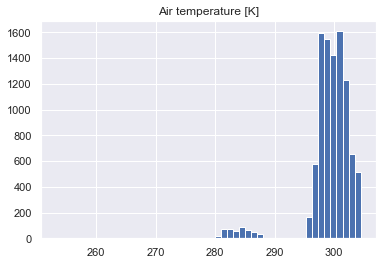

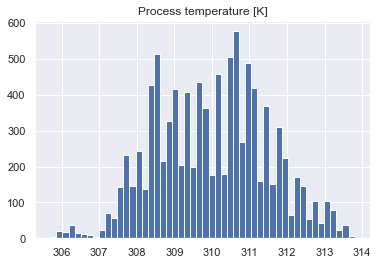

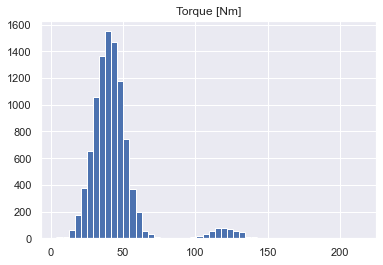

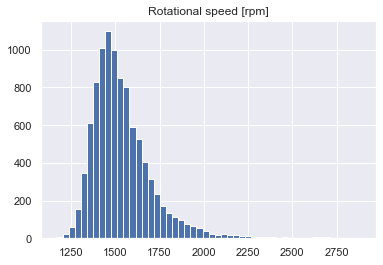

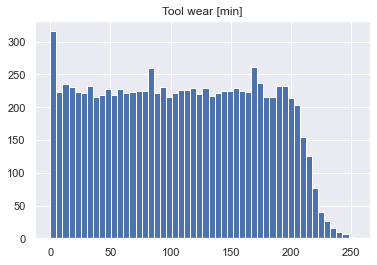

In [15]:
for feature in ['Air temperature [K]','Process temperature [K]','Torque [Nm]','Rotational speed [rpm]','Tool wear [min]']:

    plt.figure()
    plt.title(feature)
    plt.hist(machine_data[feature],bins=50)
    plt.show()

We can see obvious outliers in both Air Temperature and Torque, in each case the plots show a main distribution and a smaller shifted distribution. This seems likely to be a systematic error in how the data has been recorded, let's investigate: 

In [22]:
#split the air temperature distributions
cleaned_data=machine_data.copy()
cleaned_data=cleaned_data[(np.abs(stats.zscore(cleaned_data['Air temperature [K]'])) < 2)]
cleaned_data=cleaned_data.sort_values(by='Timestamp')

outlier_data=machine_data.copy()
outlier_data=outlier_data[(np.abs(stats.zscore(outlier_data['Air temperature [K]'])) > 2)]
outlier_data=outlier_data.sort_values(by='Timestamp')

#cleaned_data.info()

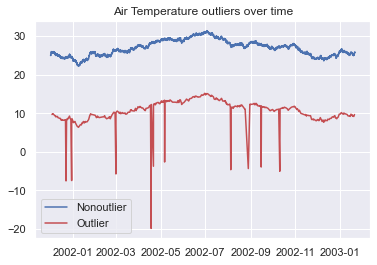

In [23]:
#plot the two distributions
plt.figure()
plt.title('Air Temperature outliers over time')
plt.plot(cleaned_data['Timestamp'],cleaned_data['Air temperature [K]'].apply(lambda z: z-273.15))
plt.plot(outlier_data['Timestamp'],outlier_data['Air temperature [K]'].apply(lambda z: z-273.15),color='r')
plt.legend(['Nonoutlier','Outlier'])
#plt.savefig('Air_temp2.png')
plt.show()

When we take a look at the outliers over time, we can clearly see the same distribution of Air Temperatures only shifted to by a constant (apart from a few outliers), confirming suspicions about a systematic error. Ideally, I would like to learn how we could apply a correction to these outliers but currently I'm not able to do this without making unreasonable assumptions abotu the data. Let's drop the outliers:  

In [30]:
#update machine_data removign outliers
machine_data=machine_data[(np.abs(stats.zscore(machine_data['Air temperature [K]'])) < 2)]
machine_data=machine_data[(np.abs(stats.zscore(machine_data['Torque [Nm]'])) < 2)]

machine_data=machine_data.sort_values(by='Timestamp')
machine_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8871 entries, M14860 to M24859
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Machine Type             8871 non-null   object        
 1   Air temperature [K]      8871 non-null   float64       
 2   Process temperature [K]  8871 non-null   float64       
 3   Rotational speed [rpm]   8871 non-null   float64       
 4   Torque [Nm]              8871 non-null   float64       
 5   Tool wear [min]          8871 non-null   int64         
 6   Target                   8871 non-null   int64         
 7   Failure Type             8871 non-null   object        
 8   Timestamp                8871 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 693.0+ KB


295.3

In [32]:
#check updated data 
'''for feature in ['Air temperature [K]','Process temperature [K]','Torque [Nm]','Rotational speed [rpm]','Tool wear [min]']:

    plt.figure()
    plt.title(feature)
    plt.hist(machine_data[feature],bins=50)
    plt.show()'''

"for feature in ['Air temperature [K]','Process temperature [K]','Torque [Nm]','Rotational speed [rpm]','Tool wear [min]']:\n\n    plt.figure()\n    plt.title(feature)\n    plt.hist(machine_data[feature],bins=50)\n    plt.show()"

# Feature relationships 

I found a few predictable relationships between our features. I'm sure no one is surpried there is a relationship between Air and Process temperature so I won't comment further here. 

<AxesSubplot:xlabel='Air temperature [K]', ylabel='Process temperature [K]'>

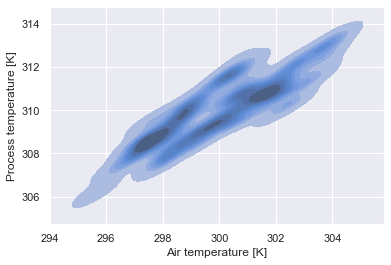

In [39]:
sns.kdeplot(data=machine_data,x='Air temperature [K]',y='Process temperature [K]',thresh=0.01,shade=True)

<AxesSubplot:xlabel='Torque [Nm]', ylabel='Rotational speed [rpm]'>

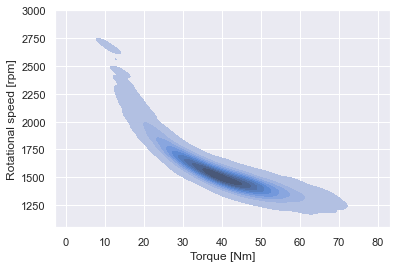

In [40]:
sns.kdeplot(data=machine_data,x='Torque [Nm]',y='Rotational speed [rpm]',thresh=0.01,shade=True)

# Break down by Failure type

The failure rate is about once ever 22 hours, let's take a look at how failures break down by type.

In [41]:
#split the data 
failure_data=machine_data[machine_data['Failure Type']!='No Failure']
working_data=machine_data[machine_data['Failure Type']=='No Failure']

In [42]:
#find total failure rate 
failure_rate=(np.shape(failure_data)[0]/np.shape(machine_data)[0])
print(failure_rate*100, 1/failure_rate)
print(np.shape(failure_data)[0])

4.463983767331755 22.401515151515152
396


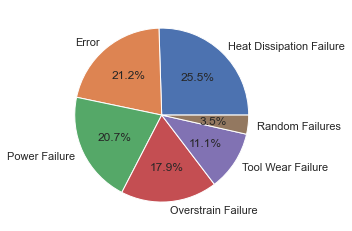

In [43]:
#plot a breakdown by failure type
plt.figure()
plt.pie(failure_data['Failure Type'].value_counts(),labels=failure_data['Failure Type'].value_counts().index,autopct='%1.1f%%')
#plt.savefig('error_pie.png')
plt.show()

With this break down in mind, it makes sense to move form the most to least common errors and see what we can learn about each

## Heat Dissipation Failure

For the fault sections, I will give a quick summary rather than breakdown my whole thought process.

The headline for Heat dissipation faults is that they all happened at a higher air temperatures (above 28.5c), which is unsurprising, but they also only occured in a short window of time. The window occured during the summer months but ended while air temepatures had not yet reached their peak. From a business perspective, this is interesting as it might indicate that action was taken to adress this issue and perhaps no further action is needed. My main recomendation for this section is to look in more detail at the time window where these faults occured, with special focus on what was done to prevent these. 

We could also see possible links between rotaional speeds and torque with these faults. 



In [44]:
Heat_diss_data=machine_data[machine_data['Failure Type']=='Heat Dissipation Failure']

print((np.shape(Heat_diss_data)[0]/np.shape(machine_data)[0])*100)
print((np.shape(Heat_diss_data)[0]/np.shape(failure_data)[0])*100)

1.1385413143952203
25.5050505050505


In [59]:
Heat_diss_data['Air temperature [K]'].min()-273.15

28.450000000000045

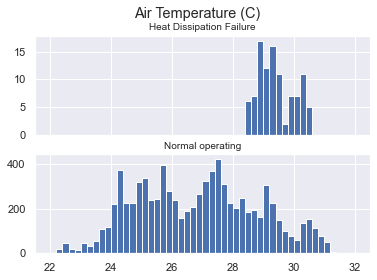

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
fig.suptitle('Air Temperature (C)')
ax1.set_title('Heat Dissipation Failure',fontsize='small')
ax2.set_title('Normal operating',fontsize='small')
ax1.hist(Heat_diss_data['Air temperature [K]'].apply(lambda z: z-273.15), bins=50,range=(22,32))
ax2.hist(working_data['Air temperature [K]'].apply(lambda z: z-273.15), bins=50,range=(22,32))
#plt.savefig('Heatdiss_airtemp.png')
plt.show()

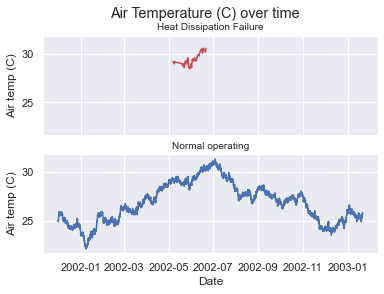

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True, sharey=True)
fig.suptitle('Air Temperature (C) over time')
ax1.set_title('Heat Dissipation Failure',fontsize='small')
ax2.set_title('Normal operating',fontsize='small')
ax1.plot(Heat_diss_data['Timestamp'],Heat_diss_data['Air temperature [K]'].apply(lambda z: z-273.15),color='r')
ax2.plot(working_data['Timestamp'],working_data['Air temperature [K]'].apply(lambda z: z-273.15))
ax1.set_ylabel('Air temp (C)')
ax2.set_ylabel('Air temp (C)')
ax2.set_xlabel('Date')
#plt.savefig('Heatdiss_overtime.png')
plt.show()

2002-05-06 16:00:00 2002-06-21 03:00:00


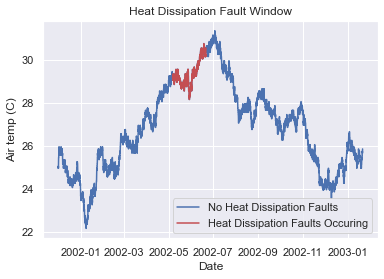

In [48]:
print(Heat_diss_data['Timestamp'].min(),Heat_diss_data['Timestamp'].max())
heat_window=machine_data[(machine_data['Timestamp']>=datetime(2002,5,6,16,0,0))&
                         (machine_data['Timestamp']<=datetime(2002,6,21,3,0,0))]
plt.figure
plt.title('Heat Dissipation Fault Window')
plt.plot(machine_data['Timestamp'],machine_data['Air temperature [K]'].apply(lambda z: z-273.15))
plt.plot(heat_window['Timestamp'],heat_window['Air temperature [K]'].apply(lambda z: z-273.15),color='r')
plt.ylabel('Air temp (C)')
plt.ylabel('Air temp (C)')
plt.xlabel('Date')
plt.legend(['No Heat Dissipation Faults', 'Heat Dissipation Faults Occuring'])
#plt.savefig('Heatdiss_overtime.png')

plt.show()

In [51]:
# two sample z test
ztezt,pval=ztest(Heat_diss_data['Air temperature [K]'],working_data['Air temperature [K]'])
if pval>0.01:
    print('accept null hypothesis', pval)
else:
    print('reject null hypothesis', pval)

reject null hypothesis 1.0569366572754293e-38


In [52]:
Heat_diss_data['Air temperature [K]'].quantile(q=0.01)-273.15

28.450000000000045

In [53]:
working_overtemp=working_data['Air temperature [K]']>301.6
working_overtemp.apply(lambda z: int(z)).mean()

0.22584070796460176

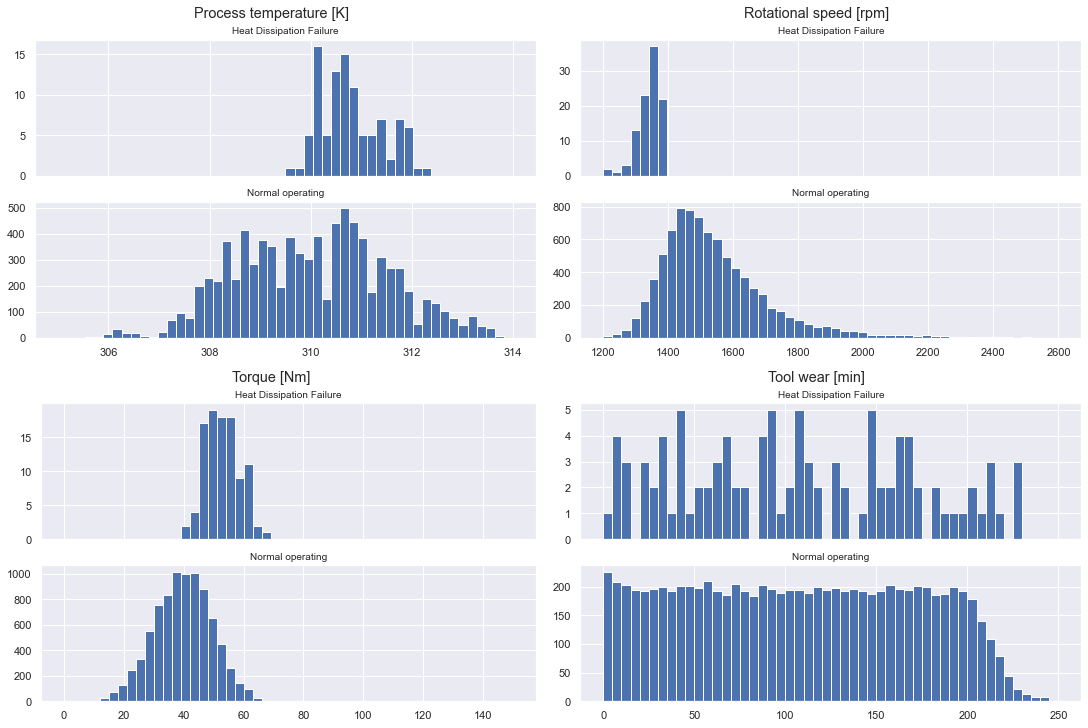

In [58]:
fig = plt.figure(constrained_layout=True,figsize=(15,10))

subfigs = fig.subfigures(2, 2)

titles=['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
data=[Heat_diss_data,working_data]
ranges=[(305,314),(1200,2600),(0,150),(0,250)]
subtitles=['Heat Dissipation Failure','Normal operating']

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(titles[outerind])
    axs = subfig.subplots(2, 1,sharex=True)
    for innerind, ax in enumerate(axs.flat):
        ax.set_title(subtitles[innerind],fontsize='small')
        ax.hist(data[innerind][titles[outerind]], bins=50,range=ranges[outerind])
#plt.savefig('Heat_diss_total.png')
plt.show()

## Error

Despite being the second most common failure, I could not find any clear patterns in these faults. Concerningly, these where not labelled as targets, suggesting that they may in fact not even be faults. My recomendation here is to investigate whether these are actually fauilures.

In [60]:
error_data=machine_data[machine_data['Failure Type']=='Error']

print((np.shape(error_data)[0]/np.shape(machine_data)[0])*100)
print((np.shape(error_data)[0]/np.shape(failure_data)[0])*100)

print(error_data['Timestamp'].min(),error_data['Timestamp'].max())

0.9469056476158269
21.21212121212121
2001-12-03 23:00:00 2003-01-16 21:00:00


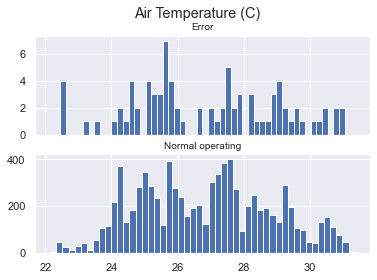

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
fig.suptitle('Air Temperature (C)')
ax1.set_title('Error',fontsize='small')
ax2.set_title('Normal operating',fontsize='small')
ax1.hist(error_data['Air temperature [K]'].apply(lambda z: z-273.15), bins=50)
ax2.hist(working_data['Air temperature [K]'].apply(lambda z: z-273.15), bins=50 )
#plt.savefig('Error_airtemp.png')
plt.show()

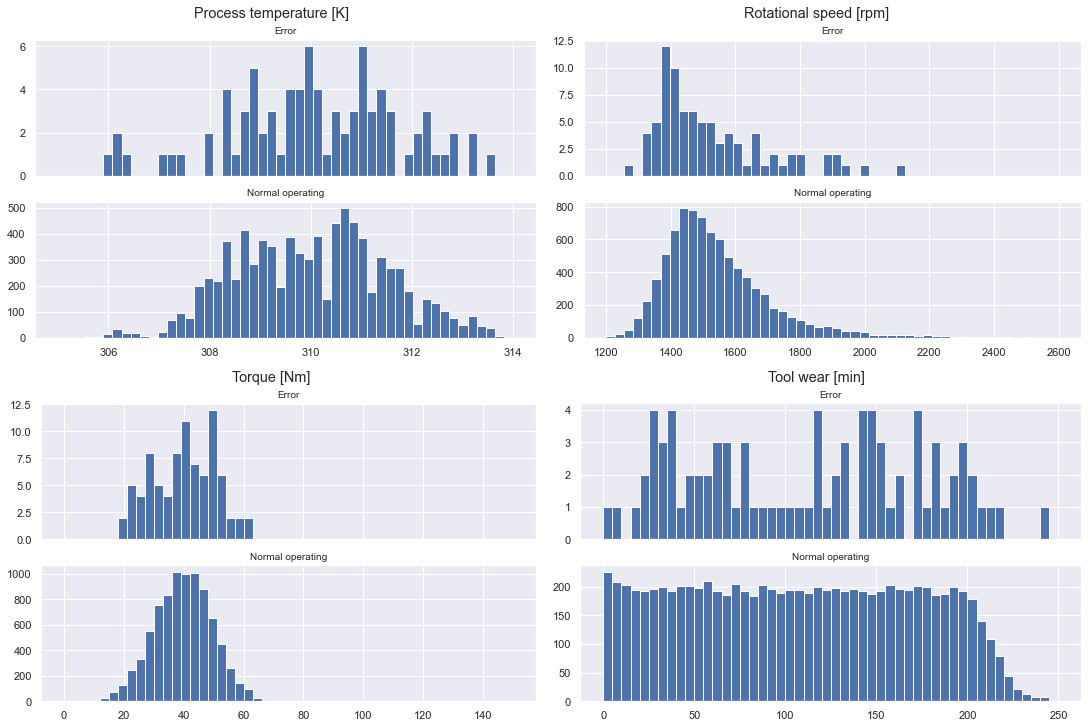

In [66]:
fig = plt.figure(constrained_layout=True,figsize=(15,10))

subfigs = fig.subfigures(2, 2)

titles=['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
data=[error_data,working_data]
ranges=[(305,314),(1200,2600),(0,150),(0,250)]
subtitles=['Error','Normal operating']

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(titles[outerind])
    axs = subfig.subplots(2, 1,sharex=True)
    for innerind, ax in enumerate(axs.flat):
        ax.set_title(subtitles[innerind],fontsize='small')
        ax.hist(data[innerind][titles[outerind]], bins=50,range=ranges[outerind])
#plt.savefig('Error_total.png')
plt.show()

## Power Failure

The big take way from this section is that there appear to be two distibutions of power failure, one with lower than expected torque and one with higher (this was also mirrored in rotational speed). The recommendation here is to consider these faults as possibly worth separating into two types that could be investigated and addressed separately. 

In [67]:
power_fail_data=machine_data[machine_data['Failure Type']=='Power Failure']

print((np.shape(power_fail_data)[0]/np.shape(machine_data)[0])*100)
print((np.shape(power_fail_data)[0]/np.shape(failure_data)[0])*100)

print(power_fail_data['Timestamp'].min(),power_fail_data['Timestamp'].max())

0.9243602750535453
20.707070707070706
2001-12-03 02:00:00 2003-01-20 14:00:00


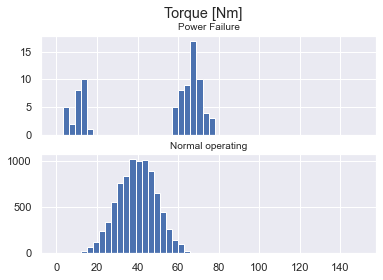

In [71]:

fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
fig.suptitle('Torque [Nm]')
ax1.set_title('Power Failure',fontsize='small')
ax2.set_title('Normal operating',fontsize='small')
ax1.hist(power_fail_data['Torque [Nm]'], bins=50,range=(0,150))
ax2.hist(working_data['Torque [Nm]'], bins=50,range=(0,150))
#plt.savefig('Powerfail_torque.png')
plt.show()

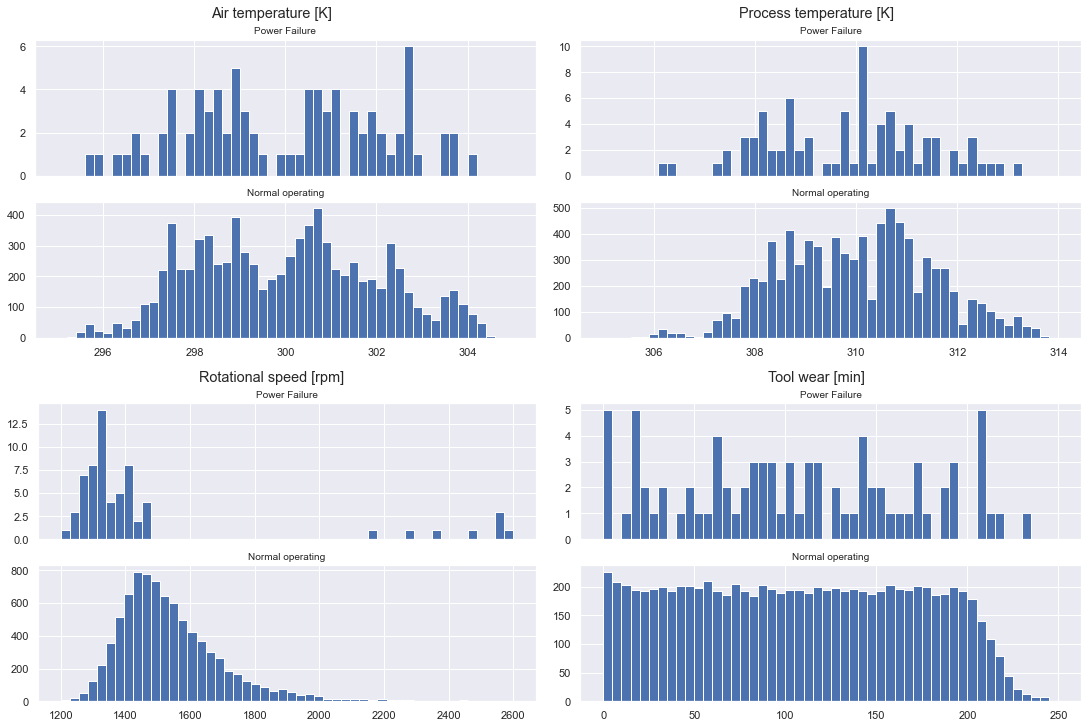

In [73]:
fig = plt.figure(constrained_layout=True,figsize=(15,10))

subfigs = fig.subfigures(2, 2)

titles=['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Tool wear [min]']
data=[power_fail_data,working_data]
ranges=[(295,305),(305,314),(1200,2600),(0,250)]
subtitles=['Power Failure','Normal operating']

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(titles[outerind])
    axs = subfig.subplots(2, 1,sharex=True)
    for innerind, ax in enumerate(axs.flat):
        ax.set_title(subtitles[innerind],fontsize='small')
        ax.hist(data[innerind][titles[outerind]], bins=50,range=ranges[outerind])
#plt.savefig('Power Failure_total.png')
plt.show()

## Overstrain Failure

99% of these faults occur at a tool wear over 180.5, compared with just 15% of normal operating. The rotaional speed and torque distributions also differ from normal, which could be useful for identifying thses faults. 

The reccomendation here is clear, look at the posibility of placing limits on tool wear. 

In [82]:
Overstrain_data=machine_data[machine_data['Failure Type']=='Overstrain Failure']

print((np.shape(Overstrain_data)[0]/np.shape(machine_data)[0])*100)
print((np.shape(Overstrain_data)[0]/np.shape(failure_data)[0])*100)

print(Overstrain_data['Timestamp'].min(),Overstrain_data['Timestamp'].max())

0.8003607259609965
17.929292929292927
2001-12-07 16:00:00 2003-01-14 14:00:00


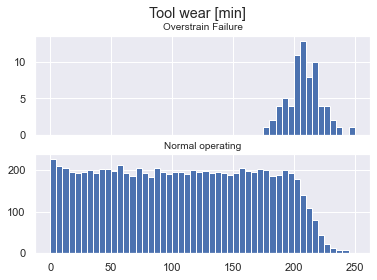

In [84]:
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
fig.suptitle('Tool wear [min]')
ax1.set_title('Overstrain Failure',fontsize='small')
ax2.set_title('Normal operating',fontsize='small')
ax1.hist(Overstrain_data['Tool wear [min]'], bins=50,range=(0,250))
ax2.hist(working_data['Tool wear [min]'], bins=50,range=(0,250))
#plt.savefig('overstrain_wear.png')
plt.show()

In [83]:
threshold=Overstrain_data['Tool wear [min]'].quantile(0.01)
working_overthreshold=working_data['Tool wear [min]']>threshold
print(threshold)
print(working_overthreshold.apply(lambda z: int(z)).mean())

180.5
0.15740412979351032


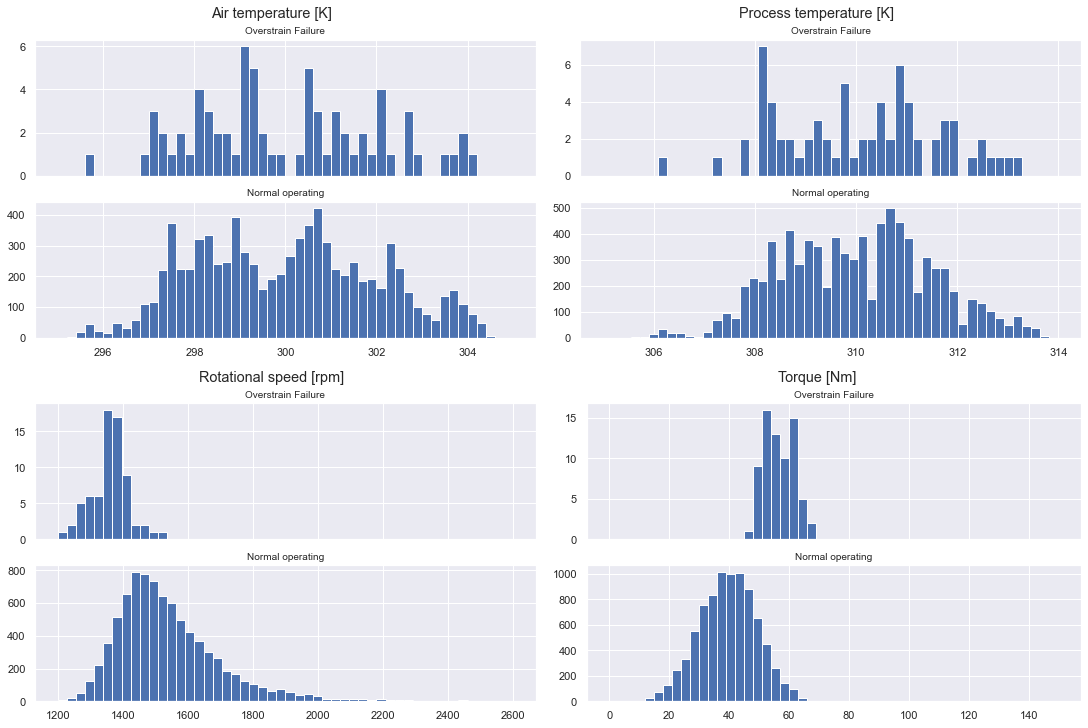

In [81]:
fig = plt.figure(constrained_layout=True,figsize=(15,10))

subfigs = fig.subfigures(2, 2)

titles=['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]']
data=[Overstrain_data,working_data]
ranges=[(295,305),(305,314),(1200,2600),(0,150)]
subtitles=['Overstrain Failure','Normal operating']

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(titles[outerind])
    axs = subfig.subplots(2, 1,sharex=True)
    for innerind, ax in enumerate(axs.flat):
        ax.set_title(subtitles[innerind],fontsize='small')
        ax.hist(data[innerind][titles[outerind]], bins=50,range=ranges[outerind])
#plt.savefig('OverstrainFailure_total.png')
plt.show()

## Tool Wear Failure

99% of these failures occur at tool wear over 198.9, compared with only 7.5% of normal operating. The recomendation here is clear, look at replacing tools before this threshold is reached. 

In [85]:
Tool_fail_data=machine_data[machine_data['Failure Type']=='Tool Wear Failure']

print((np.shape(Tool_fail_data)[0]/np.shape(machine_data)[0])*100)
print((np.shape(Tool_fail_data)[0]/np.shape(failure_data)[0])*100)

print(Tool_fail_data['Timestamp'].min(),Tool_fail_data['Timestamp'].max())

0.49599819637019504
11.11111111111111
2001-12-04 05:00:00 2003-01-11 14:00:00


In [86]:
threshold=Tool_fail_data['Tool wear [min]'].quantile(0.01)
working_overthreshold=working_data['Tool wear [min]']>threshold
print(threshold)
print(working_overthreshold.apply(lambda z: int(z)).mean())



198.86
0.0751622418879056


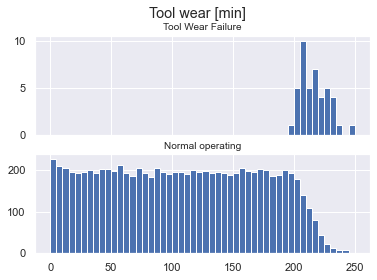

In [93]:
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
fig.suptitle('Tool wear [min]')
ax1.set_title('Tool Wear Failure',fontsize='small')
ax2.set_title('Normal operating',fontsize='small')
ax1.hist(Tool_fail_data['Tool wear [min]'], bins=50,range=(0,250))
ax2.hist(working_data['Tool wear [min]'], bins=50,range=(0,250))
#plt.savefig('tool_wear.png')
plt.show()

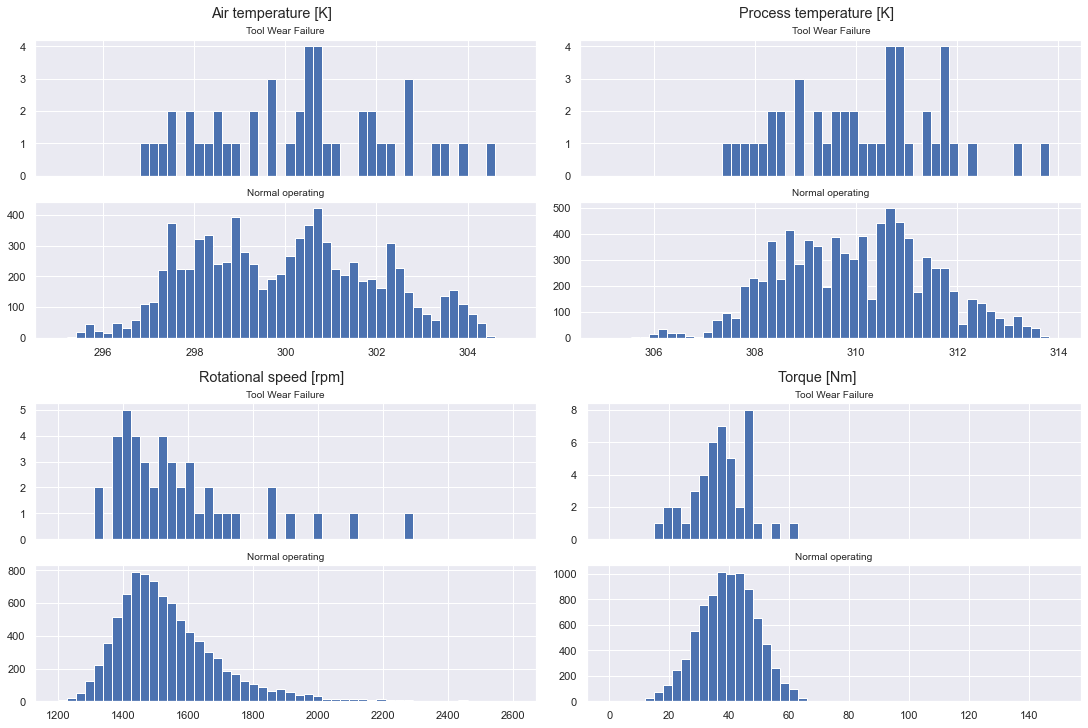

In [92]:
fig = plt.figure(constrained_layout=True,figsize=(15,10))

subfigs = fig.subfigures(2, 2)

titles=['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]']
data=[Tool_fail_data,working_data]
ranges=[(295,305),(305,314),(1200,2600),(0,150)]
subtitles=['Tool Wear Failure','Normal operating']

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(titles[outerind])
    axs = subfig.subplots(2, 1,sharex=True)
    for innerind, ax in enumerate(axs.flat):
        ax.set_title(subtitles[innerind],fontsize='small')
        ax.hist(data[innerind][titles[outerind]], bins=50,range=ranges[outerind])
#plt.savefig('Tool_wear_Failure_total.png')
plt.show()

## Random Failures

There isn't much to say here, the random failures are similarly distributed as normal operating, as you might expect. 

In [94]:
random_fail_data=machine_data[machine_data['Failure Type']=='Random Failures']

print((np.shape(random_fail_data)[0]/np.shape(machine_data)[0])*100)
print((np.shape(random_fail_data)[0]/np.shape(failure_data)[0])*100)
print(random_fail_data['Timestamp'].min(),random_fail_data['Timestamp'].max())

0.15781760793597113
3.535353535353535
2002-01-20 21:00:00 2002-10-24 20:00:00


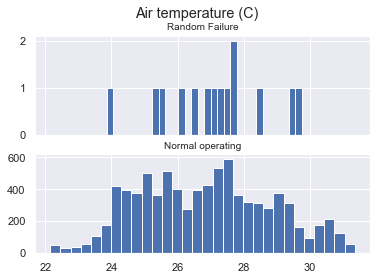

In [95]:
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
fig.suptitle('Air temperature (C)')
ax1.set_title('Random Failure',fontsize='small')
ax2.set_title('Normal operating',fontsize='small')
ax1.hist(random_fail_data['Air temperature [K]'].apply(lambda z: z-273.15), bins=30 )
ax2.hist(working_data['Air temperature [K]'].apply(lambda z: z-273.15), bins=30 )
#plt.savefig('random_air.png')
plt.show()

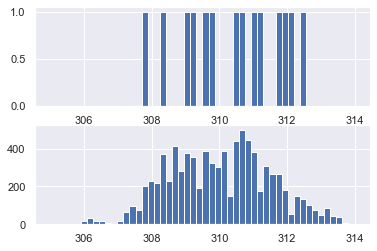

In [96]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(random_fail_data['Process temperature [K]'], bins=50,range=(305,314))
ax2.hist(working_data['Process temperature [K]'], bins=50,range=(305,314))
plt.show()

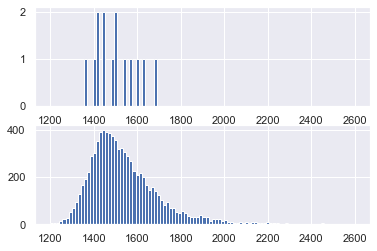

In [97]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(random_fail_data['Rotational speed [rpm]'], bins=100,range=(1200,2600))
ax2.hist(working_data['Rotational speed [rpm]'], bins=100,range=(1200,2600))
plt.show()

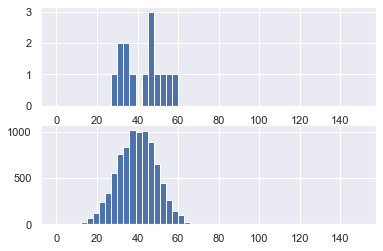

In [98]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(random_fail_data['Torque [Nm]'], bins=50,range=(0,150))
ax2.hist(working_data['Torque [Nm]'], bins=50,range=(0,150))
plt.show()

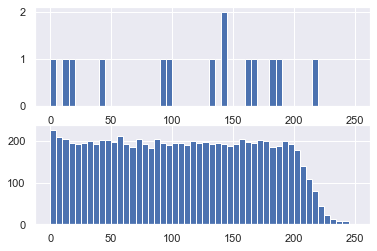

In [99]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(random_fail_data['Tool wear [min]'], bins=50,range=(0,250))
ax2.hist(working_data['Tool wear [min]'], bins=50,range=(0,250))
plt.show()

# Modelling 

Finally, I took some time to experiment with a machine learnign approach. I can see a few possible uses of machine learning here, either predicting when faults might occur or identifying the type of fault that has occured. Though this showed some promise, it's not the most relevant or focused part of my analysis so probably could have been left as a theoretical discussion.

In [101]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

In [102]:
X_total=machine_data[['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']].copy()
y_total=machine_data['Failure Type']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, random_state = 0,test_size=0.25)

In [106]:
print(np.shape(X_train),np.shape(X_test))
print(np.shape(y_train),np.shape(y_test))

(6653, 5) (2218, 5)
(6653,) (2218,)


In [107]:
tree_model=DecisionTreeClassifier(max_depth = 10,min_samples_split=20,random_state=0).fit(X_train, y_train)
pd.Series(tree_model.predict(X_train)).value_counts()

No Failure                  6473
Heat Dissipation Failure      80
Power Failure                 52
Overstrain Failure            42
Error                          4
Tool Wear Failure              1
Random Failures                1
dtype: int64

In [108]:
baseline=DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

In [109]:
print('macro')
print(f1_score(y_train, baseline.predict(X_train), average='macro'))
print(f1_score(y_test, baseline.predict(X_test), average='macro'))

print('micro')
print(f1_score(y_train, baseline.predict(X_train), average='micro'))
print(f1_score(y_test, baseline.predict(X_test), average='micro'))

macro
0.1395619604138749
0.13969716919025676
micro
0.954907560499023
0.9567177637511272


In [110]:
print('macro')
print(f1_score(y_train, tree_model.predict(X_train), average='macro'))
print(f1_score(y_test, tree_model.predict(X_test), average='macro'))

print('micro')
print(f1_score(y_train, tree_model.predict(X_train), average='micro'))
print(f1_score(y_test, tree_model.predict(X_test), average='micro'))

macro
0.5507918317738295
0.4441032433586554
micro
0.9774537802495115
0.9711451758340848


In [111]:
'''plt.figure(figsize=(20,20))
plot_tree(tree_model)
plt.show()'''

'plt.figure(figsize=(20,20))\nplot_tree(tree_model)\nplt.show()'

In [112]:
RF_model=RandomForestClassifier(max_depth=10,min_samples_split=20,random_state=0).fit(X_train, y_train)

In [113]:
print(f1_score(y_train, RF_model.predict(X_train), average='macro'))
print(f1_score(y_test, RF_model.predict(X_test), average='macro'))

0.4875213405818054
0.4716778238372923
